# XRF Core Scan Calibration: IODP Site U1474
Daniel Babin$^1$, Sidney Hemming$^1$, Allison Franzese$^{1,2}$, and Luis Tejada$^{1,2}$ <br>
1. Lamont Doherty Earth Observatory, 61 Rte 9W, Palisades, NY 10964 <br>
2. Hostos Community College, 450 Grand Concourse, The Bronx, NY 10451 <br>

An essentially continuous record of sediment chemistry at U1474 is available in the form of XRF core scan data, collected on an Itrax Core Scanner in the Core Repository at Lamont-Doherty Earth Observatory. This technique bombards the surface of the core with X-rays, and the resulting spectra measured yields relative abundance of elements. At 30 kV and 55 mA settings, measurements were applied at 2 mm intervals with an exposure time of 2 seconds along the 252 m length of each core in the U1474 splice using a Cr tube. Due to shipping error, one core (U1474E 17; Sections 1-3) did not reach Lamont-Doherty Earth Observatory. <br>

We will import the XRF data as a dataframe using pandas. The data takes the form of "counts," or relative abundances, of elements at 2 mm depth intervals along the 255 m long length of the core "Splice." Also included in the raw data are descriptive information about the Site and Expedition, as well as information about machine settings during scanning. I list the columns below.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import interpolate
from scipy import signal
from scipy import stats
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

# Make Data Path and Figure Path
These are "input" and "output" paths for the program to read and write data.

In [16]:
data_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Data/'
figure_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Figures/'
table_path='/Users/danielbabin/Documents/GitHub/U1474_XRF_Data_Report/Tables/'

# Functions

In [17]:
from scipy import signal
def smooth(df,sig):
    gaus=signal.gaussian(3*sig,sig)
    gaus=gaus/sum(gaus)
    smooth_df=df.rolling(3*sig,min_periods=3*sig,center=True).apply(func=lambda x: np.dot(gaus,x),raw=True)
    return smooth_df

# Import XRF Data

In [59]:
xrf=pd.read_csv(data_path+'integrated_xrf_data_raw.csv')
D4H1=pd.read_csv(data_path+'D4H1.csv')
xrf=pd.concat([xrf,D4H1],sort=False)
xrf.set_index('Depth CCSF (m)',drop=False,inplace=True)
xrf.sort_index(inplace=True)

In [127]:
xrf.to_csv(table_path+'Table-5 2cm-20sec xrf data.csv')

In [60]:
old_xrf=pd.read_csv(data_path+'U1474_XRF_Splice rereduced.csv',low_memory=False,index_col='Depth CCSF (m)')
old_xrf=old_xrf[old_xrf['In the Splice?']==True]
old_xrf=old_xrf.sort_index().copy()
old_xrf=old_xrf[~old_xrf.index.duplicated(keep='first')].copy()
old_xrf=old_xrf[(old_xrf[['Al','Si','K','Ca','Ti','Fe']] != 0).all(1)]

In [128]:
old_xrf.to_csv(table_path+'Table-4 2mm-2sec xrf data.csv')

# Clean the XRF Data
Here in this section will be the bulk of our data cleaning and preparation

### Sort by depth, delete duplicates, and save "cleaned" raw data
Saving the clean raw data now will allow other scientists, interested in reanalyzing my data, to have it in its most basic form

In [61]:
clean_xrf = xrf[~xrf.index.duplicated(keep='first')].sort_index().copy()
xrf=clean_xrf

In [62]:
xrf.columns

Index(['Depth CCSF (m)', 'filename', 'position (mm)', 'sample surface',
       'validity', 'E-gain', 'E-offset', 'F-slope', 'F-offset', 'cps', 'MSE',
       'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V',
       'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Ru',
       'Rh', 'Pd', 'Cd', 'Sb', 'Ba', 'Ce', 'Pr', 'Nd', 'Tb', 'Tm', 'Lu', 'Hf',
       'Os', 'Ir', 'Pt', 'Hg', 'Tl', 'Pb', 'Th', 'Pa', 'U', 'Cr kb',
       'Ca ka-a sum', 'Ca ka-b sum', 'S2', 'W la', 'W la scat', 'W lb1',
       'W lb1 scat', 'W lb2', 'W lb2 scat', 'Cr inc', 'Cr coh', 'Dt',
       'Unnamed: 68', 'SectionFile', 'SectionLabel', 'File', 'Core',
       'Section Top Depth CCSF (m)', 'Section Bottom Depth CCSF (m)',
       'In Splice'],
      dtype='object')

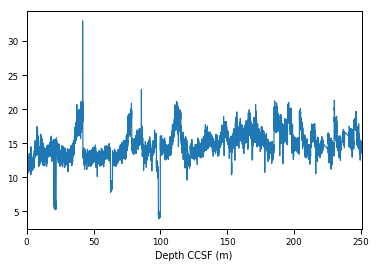

In [63]:
xrf['MSE'].plot()

# Visualize Complete XRF Dataset

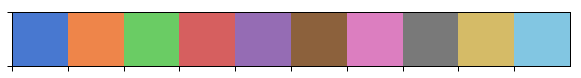

In [64]:
colors=sns.color_palette('muted',10)
sns.palplot(colors)

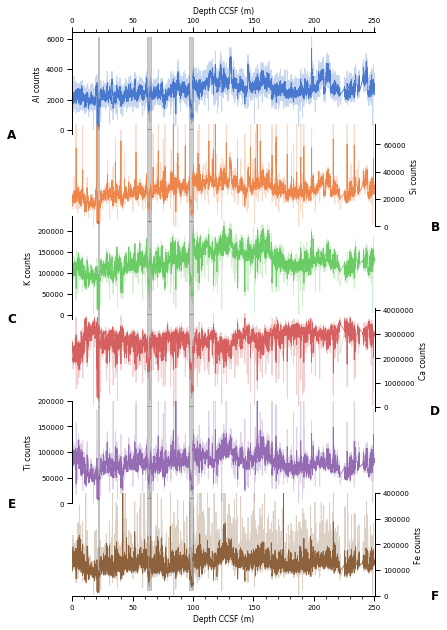

In [303]:
fig,axes=plt.subplots(nrows=6,figsize=(6,9))
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)

for i,e in enumerate(['Al','Si','K','Ca','Ti','Fe']):
    xrf[e].plot(ax=axes[i],color=colors[i],lw=lw)
    (old_xrf[e]*10).plot(ax=axes[i],color=colors[i],lw=lw,zorder=-2,alpha=.3)
    axes[i].set_ylabel(e+' counts')
    axes[i].axvspan(xmin=21,xmax=22,ymin=.05,ymax=.95,color='k',alpha=.2)
    axes[i].axvspan(xmin=62,xmax=65,ymin=.05,ymax=.95,color='k',alpha=.2)
    axes[i].axvspan(xmin=97,xmax=100,ymin=.05,ymax=.95,color='k',alpha=.2)

labels=['A','C','E']
axs=[0,2,4]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(-.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

labels=['B','D','F']
axs=[1,3,5]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(1+.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

axes[1].set_ylim(0,75000)
axes[4].set_ylim(0,200000)
axes[5].set_ylim(0,400000)

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth CCSF (m)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth CCSF (m)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-2 counts.png',dpi=700)

Notice the sections highlighted in grey have relatively low counts. Checking the raw data reveals they were scanned at low amperage.

In [313]:
xrf['MSE']

Depth CCSF (m)
0.06      12.27
0.08      12.56
0.10      13.35
0.12      13.32
0.14      12.54
0.16      13.30
0.18      13.04
0.20      12.77
0.22      12.67
0.24      12.36
0.26      12.68
0.28      12.95
0.30      12.31
0.32      12.88
0.34      13.39
0.36      13.03
0.38      12.12
0.40      12.50
0.42      12.16
0.44      11.65
0.46      12.22
0.48      12.25
0.50      13.46
0.52      12.96
0.54      12.60
0.56      12.45
0.58      12.42
0.60      12.42
0.62      12.04
0.64      12.37
          ...  
249.77    14.05
249.79    13.57
249.81    14.57
249.83    13.49
249.87    14.68
249.89    15.30
249.91    14.33
249.93    15.04
249.95    15.16
249.97    14.38
249.99    13.92
250.01    14.73
250.03    14.55
250.05    14.38
250.07    13.95
250.09    14.54
250.11    14.31
250.13    14.17
250.15    14.81
250.17    14.78
250.19    13.89
250.21    14.96
250.23    14.27
250.25    14.80
250.27    14.16
250.29    14.94
250.31    14.71
250.33    14.46
250.35    14.64
250.37    14.57
Name: MSE

# Problem Sections
It seems as if multiplying each of the 4 sections by a scalar, different for each section but identical for all 6 elements, does a relatively good job fixing the counts. Aluminum is an exception. Counts for aluminum are relatively low, and thus the signal/noise ratio is low. Scaling the elements should not affect ratios, commonly used for XRF core scanning, so this manipulation might not matter much. <br> <br> Additionally, we repair the quantity reflecting the degree of cohesive scatter ("Cr coh"), because we found that normalizing terrigenously derived elements (K,Fe,Ti), to this factor improves the correlation with the calibration samples. This is shown later. <br> <br> Here we show how we scaled each mis-scanned section:

In [66]:
e_list=['Al','Si','K','Ti','Fe']

#### Section D4H1

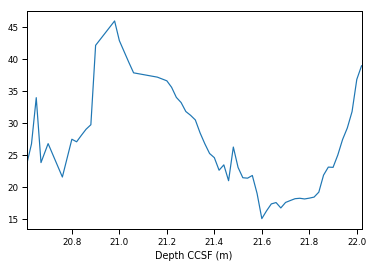

In [67]:
(xrf[xrf['SectionLabel'] == 'U1474D_4H1']['Ca']/xrf[xrf['SectionLabel'] == 'U1474D_4H1']['Fe']).plot()

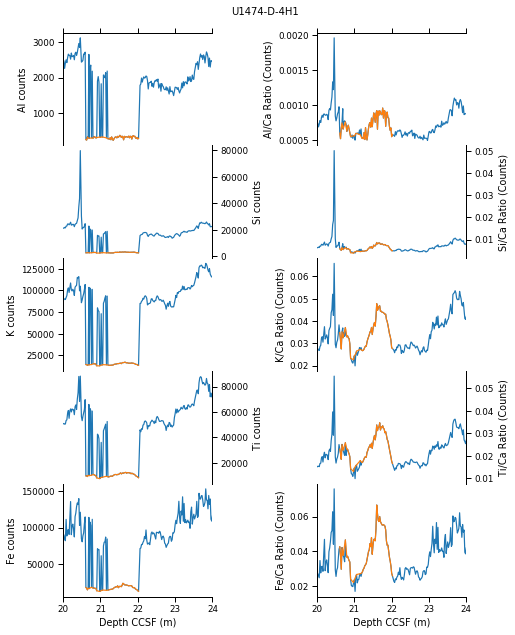

In [68]:
ids=xrf[xrf['SectionLabel'] == 'U1474D_4H1'].index

fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(8,9),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[20:24].plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_4H1'][e]).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth CCSF (m)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[20:24].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_4H1'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_4H1']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth CCSF (m)')
    
plt.suptitle('U1474-D-4H1',size=10)
plt.subplots_adjust(wspace=.7,hspace=0,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'problem_U1474-D-4H1.png',dpi=500)

### Section D8H3

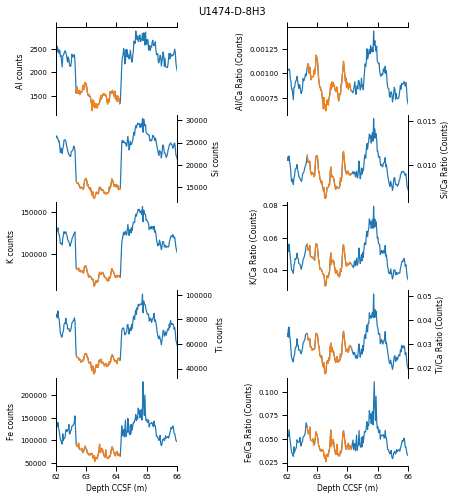

In [310]:
ids=xrf[xrf['SectionLabel'] == 'U1474D_8H3'].index

fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(7,7),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[62:66].plot(ax=axes[i,0])
    ((xrf[xrf['SectionLabel'] == 'U1474D_8H3'][e])).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth CCSF (m)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[62:66].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_8H3'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_8H3']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth CCSF (m)')
    
plt.suptitle('U1474-D-8H3',size=10)
plt.subplots_adjust(wspace=.9,hspace=0,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-6 problem_U1474-D-8H3.png',dpi=500)

### Sections D11H4 and D11H5

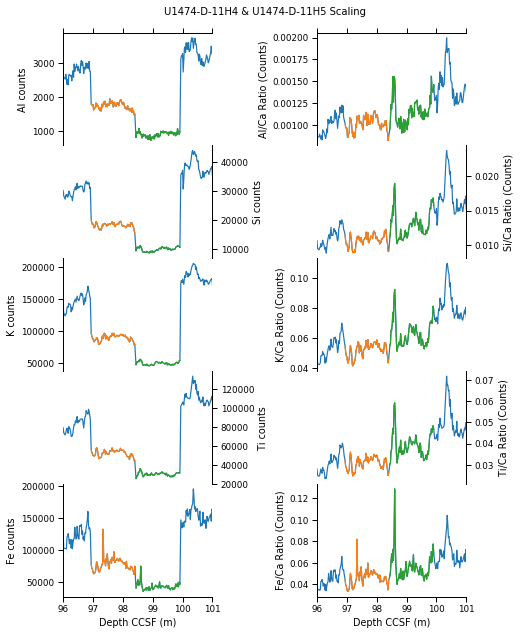

In [71]:
fig,axes=plt.subplots(ncols=2,nrows=5,figsize=(8,9),sharex=True)
sns.set_context('paper',font_scale=1)

lw=.8
ms=1.5

for i in [0,1]:
    sns.despine(ax=axes[0,i],right=True,bottom=True,top=False)
    axes[0,i].patch.set_alpha(0)

for i in [0,1]:
    for i,ax in enumerate(axes[1:-1,i]):
        if i%2==1:
            sns.despine(ax=ax,bottom=True)
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)
        else:
            sns.despine(ax=ax,left=True,bottom=True,right=False)
            ax.yaxis.set_label_position("right")
            ax.patch.set_alpha(0)
            ax.xaxis.set_visible(False)

for i in [0,1]:
    axis=axes[-1,i]
    if len(axes)%2==1:
        sns.despine(ax=axis)
        axis.patch.set_alpha(0)
    else:
        sns.despine(ax=axis,left=True,right=False)
        axis.yaxis.set_label_position("right")
        axis.patch.set_alpha(0)
    
    
for i,e in enumerate(e_list):
    xrf[e].loc[96:101].plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_11H4'][e]).plot(ax=axes[i,0])
    (xrf[xrf['SectionLabel'] == 'U1474D_11H5'][e]).plot(ax=axes[i,0])
    axes[i,0].set_ylabel(e+' counts')
    axes[i,0].set_xlabel('')
axes[4,0].set_xlabel('Depth CCSF (m)')

for i,e in enumerate(e_list):
    (xrf[e]/xrf['Ca']).loc[96:101].plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_11H4'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_11H4']['Ca'])).plot(ax=axes[i,1])
    ((xrf[xrf['SectionLabel'] == 'U1474D_11H5'][e])/(xrf[xrf['SectionLabel'] == 'U1474D_11H5']['Ca'])).plot(ax=axes[i,1])
    axes[i,1].set_ylabel(e+'/Ca Ratio (Counts)')
axes[4,0].set_xlabel('Depth CCSF (m)')
    
plt.suptitle('U1474-D-11H4 & U1474-D-11H5 Scaling',size=10)
plt.subplots_adjust(wspace=.7,hspace=0,top=.94,bottom=.07,right=.85,left=.15)

# Visualize Ratios

No long sections have anomalously high MSE, which would be expected for a problematic section

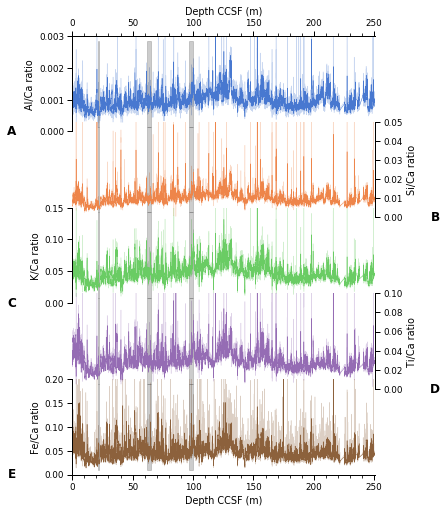

In [304]:
fig,axes=plt.subplots(nrows=5,figsize=(6,7))
sns.set_context('paper',font_scale=1)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)

color_list=[0,1,2,4,5]
for i,e in enumerate(['Al','Si','K','Ti','Fe']):
    (xrf[e]/xrf['Ca']).plot(ax=axes[i],color=colors[color_list[i]],lw=lw)
    (old_xrf[e]/old_xrf['Ca']).plot(ax=axes[i],color=colors[color_list[i]],lw=lw,zorder=-2,alpha=.3)
    axes[i].set_ylabel(e+'/Ca ratio')
    axes[i].axvspan(xmin=21,xmax=22,ymin=.05,ymax=.95,color='k',alpha=.2)
    axes[i].axvspan(xmin=62,xmax=65,ymin=.05,ymax=.95,color='k',alpha=.2)
    axes[i].axvspan(xmin=97,xmax=100,ymin=.05,ymax=.95,color='k',alpha=.2)

labels=['A','C','E']
axs=[0,2,4]

for i in np.arange(0,3): 
    axes[axs[i]].annotate(labels[i],xy=(-.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')

labels=['B','D']
axs=[1,3]

for i in np.arange(0,2): 
    axes[axs[i]].annotate(labels[i],xy=(1+.2,0),
        xycoords='axes fraction',horizontalalignment='center',
        verticalalignment='center',size=12,fontweight='bold')
    
axes[0].set_ylim(0,.003)
axes[1].set_ylim(0,.05)
axes[2].set_ylim(0,.15)
axes[3].set_ylim(0,.1)
axes[4].set_ylim(0,0.2)

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth CCSF (m)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth CCSF (m)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-3 counts_ratios.png',dpi=700)

# Compare XRF data to Calibration Dataset
It is common to calibrate X-Ray Flourescense data with well constrained concentration data. Here we provide elemental flux fusion concentrations of discrete sediment samples at different core depths for our calibration.
At this point, we can assess the quality of our raw data by comparing the xrf counts, relative abundances, to absolute concentrations from our calibration dataset
### Import Calibration Dataset

In [136]:
reference_conc_raw=pd.read_csv(data_path+'calibration_samples.csv')
reference_conc_raw.set_index('Depth CCSF (m)',inplace=True)
reference_conc=reference_conc_raw[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']].copy()

In [137]:
reference_conc

,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3
Depth CCSF (m),,,,,,
1.000,12.821383,48.561570,1.005699,28.380715,0.699535,4.501504
5.990,13.586487,49.320943,1.271016,22.179350,0.767801,5.175794
10.365,11.688655,39.075759,0.831869,37.373422,0.539126,3.292818
16.963,12.356475,40.897026,0.844932,33.592760,0.596520,4.397411
19.963,12.108119,40.005419,0.921142,35.008892,0.580988,4.036261
30.626,12.332047,47.385001,1.059318,30.230232,0.645679,4.205579
48.030,14.203124,51.849116,1.809090,22.941697,0.752261,6.285378
52.610,12.791741,45.451663,1.350100,31.832391,0.664023,4.387888
65.060,13.546968,49.643353,1.542290,24.561311,0.704023,5.636540


In [138]:
e='CaO'
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios[str('Al2O3/'+e)]=reference_conc['Al2O3']/reference_conc[e]
ref_conc_ratios[str('SiO2/'+e)]=reference_conc['SiO2']/reference_conc[e]
ref_conc_ratios[str('K2O/'+e)]=reference_conc['K2O']/reference_conc[e]
ref_conc_ratios[str('TiO2/'+e)]=reference_conc['TiO2']/reference_conc[e]
ref_conc_ratios[str('Fe2O3/'+e)]=reference_conc['Fe2O3']/reference_conc[e]

### Prepare "Counts" dataframe for comparison
We need to make an dataframe of xrf counts identical in size to the calibration data (reference_conc), extracted from the xrf counts dataframe at the depth of the calibration samples. This way, we can directly compare counts at a depth to concentration at a depth.
<br> cts_check will be this dataframe. Right now it is empty.

In [139]:
cts_check=pd.DataFrame(columns=['Al','Si','K','Ca','Ti','Fe'])

Here we first make a dataframe of just the elements we want from the clean xrf data. We then sort through this dataframe to find the depths of the calibration samples, and then add those measurements to the dataframe "cts_check"

In [140]:
xrf_check=xrf[['Al','Si','K','Ca','Ti','Fe']]
cts_check=xrf_check.reindex(reference_conc.index,method='nearest')
# for i in reference_conc.index:
#     idx=xrf_check.index.get_loc(i,method='nearest')
#     cts_check.loc[xrf_check.iloc[idx].name]=xrf_check.iloc[idx]
    
e='Ca'
cts_check_ratios=pd.DataFrame(index=cts_check.index)
cts_check_ratios[str('Al/'+e)]=cts_check['Al']/cts_check[e]
cts_check_ratios[str('Si/'+e)]=cts_check['Si']/cts_check[e]
cts_check_ratios[str('K/'+e)]=cts_check['K']/cts_check[e]
cts_check_ratios[str('Ti/'+e)]=cts_check['Ti']/cts_check[e]
cts_check_ratios[str('Fe/'+e)]=cts_check['Fe']/cts_check[e]

### Define function r2 to assess correlation

In [141]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

### Compare raw data and calibration data to assess quality

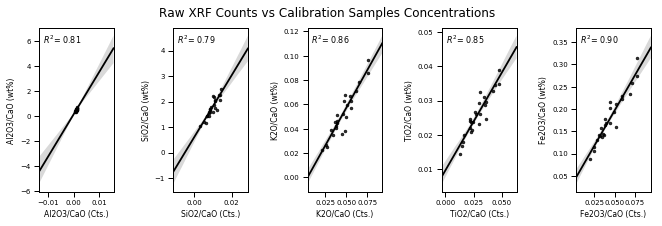

In [142]:
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(cts_check_ratios.iloc[:,i],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios.iloc[:,i],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Raw XRF Counts vs Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=.8,right=.95,left=.1)

## Convert counts to concentrations
We convert xrf counts, relative abundance, to absolute concentrations using the procedure of Weltje et al. (2008, Calibration of XRF core scanners for quantitative geochemical logging of sediment cores: Theory and application, _Earth and Planetary Science Letters_, https://doi.org/10.1016/j.epsl.2008.07.054). The procedure uses a Univariate log-ratio calibration. In our dataset, we compare all elements to Ca, as recommended by Weltje et al.

### Create dataframe of ratios from XRF core scans

In [143]:
e='Ca'
xrf_ratios=pd.DataFrame(index=xrf.index)
xrf_ratios[str('Al/'+e)]=xrf['Al']/xrf[e]
xrf_ratios[str('Si/'+e)]=xrf['Si']/xrf[e]
xrf_ratios[str('K/'+e)]=xrf['K']/xrf[e]
xrf_ratios[str('Ca/'+e)]=xrf['Ca']/xrf[e]
xrf_ratios[str('Ti/'+e)]=xrf['Ti']/xrf[e]
xrf_ratios[str('Fe/'+e)]=xrf['Fe']/xrf[e]

### Create dataframe of ratios from Flux Fusion Calibration Dataset

In [144]:
e='CaO'
ref_conc_ratios=pd.DataFrame(index=reference_conc.index)
ref_conc_ratios[str('Al2O3/'+e)]=reference_conc['Al2O3']/reference_conc[e]
ref_conc_ratios[str('SiO2/'+e)]=reference_conc['SiO2']/reference_conc[e]
ref_conc_ratios[str('K2O/'+e)]=reference_conc['K2O']/reference_conc[e]
ref_conc_ratios[str('TiO2/'+e)]=reference_conc['TiO2']/reference_conc[e]
ref_conc_ratios[str('Fe2O3/'+e)]=reference_conc['Fe2O3']/reference_conc[e]

### Extract XRF core scan ratio at depth of calibrations samples
First extract counts at depth

In [145]:
cts_check=pd.DataFrame(columns=reference_conc.columns)
cts_check_ratios=xrf_ratios.reindex(ref_conc_ratios.index,method='nearest')
cts_check_ratios.rename(columns={'Al/Ca':'Al2O3/CaO','Si/Ca':'SiO2/CaO','K/Ca':'K2O/CaO',
                                 'Ca/Ca':'CaO/CaO','Ti/Ca':'TiO2/CaO','Fe/Ca':'Fe2O3/CaO'},inplace=True)

### Parameter Estimation
These are the parameters of the univariate log-ratio calibration of Weltje et al. 2008, as described in the supplementary information.

In [146]:
yis={}
for ratio in ref_conc_ratios.columns:
    yis[ratio]=np.array([np.log(ref_conc_ratios[ratio]),np.log(cts_check_ratios[ratio])]).transpose()
    
y_bars={}
for ratio in ref_conc_ratios.columns:
    y_bars[ratio]=np.array([yis[ratio][:,0].mean(),yis[ratio][:,1].mean()])
    
xis={}
for ratio in ref_conc_ratios.columns:
    xis[ratio]=np.array([yis[ratio][:,0]-y_bars[ratio][0],yis[ratio][:,1]-y_bars[ratio][1]]).transpose()
    
xtxs={}
for ratio in ref_conc_ratios.columns:
    xtxs[ratio]=np.dot(xis[ratio].transpose(),xis[ratio])

Fs={}
for ratio in ref_conc_ratios.columns:
    Fs[ratio]=(xtxs[ratio][0,0]-xtxs[ratio][1,1])/(2*xtxs[ratio][1,0])

Gs={}
for ratio in ref_conc_ratios.columns:
    Gs[ratio]=Fs[ratio]+np.sqrt(np.square(Fs[ratio])+1)

a_s={}
for ratio in ref_conc_ratios.columns:
    a_s[ratio]=Gs[ratio]/(np.sqrt(Gs[ratio])+1)
    
b_s={}
for ratio in ref_conc_ratios.columns:
    b_s[ratio]=1/(np.sqrt(Gs[ratio])+1)

alphas={}
for ratio in ref_conc_ratios.columns:
    alphas[ratio]=a_s[ratio]/b_s[ratio]
betas={}
for ratio in ref_conc_ratios.columns:
    betas[ratio]=y_bars[ratio][0]-alphas[ratio]*y_bars[ratio][1]

In [302]:
a='α'
b='β'
pd.DataFrame([alphas,betas],index=[a,b]).to_csv(table_path+'Table-7 alpha_beta.csv')

In [148]:
betas

{'Al2O3/CaO': 4.016113836189334,
 'SiO2/CaO': 3.5218441974131465,
 'K2O/CaO': 0.763480761439864,
 'TiO2/CaO': -1.2922903851939562,
 'Fe2O3/CaO': 0.8661685705423043}

## Log XRF Scans

In [149]:
xrf_ratios.rename(columns={'Al/Ca':'Al2O3/CaO','Si/Ca':'SiO2/CaO','K/Ca':'K2O/CaO',
                                 'Ca/Ca':'CaO/CaO','Ti/Ca':'TiO2/CaO','Fe/Ca':'Fe2O3/CaO'},inplace=True)
xrf_log=np.log(xrf_ratios)

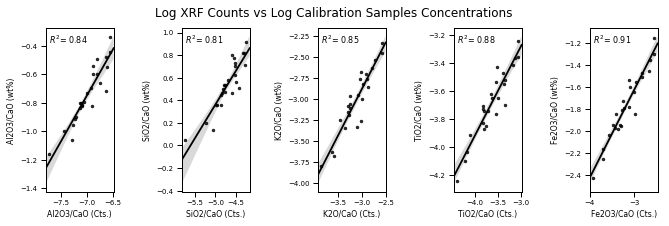

In [150]:
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col]),
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col])).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Log XRF Counts vs Log Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=1,right=.95,left=.1)

## Calibrate XRF Scans

In [151]:
ln_wij_over_wid_xrf={}
for ratio in ref_conc_ratios.columns:
    ln_wij_over_wid_xrf[ratio]=alphas[ratio]*xrf_log[ratio]+betas[ratio]

In [152]:
df_ln_wij_over_wid_xrf=pd.DataFrame(ln_wij_over_wid_xrf)
df_ln_wij_over_wid_xrf=df_ln_wij_over_wid_xrf[[str('Al2O3/'+e),str('SiO2/'+e),
                                               str('K2O/'+e),
                                               str('TiO2/'+e),str('Fe2O3/'+e)]]
df_ln_wij_over_wid_xrf[str(e+'/'+e)]=0

### Get out of log space and into concentrations

In [153]:
tot=reference_conc[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']].sum(axis=1).mean()

In [272]:
calibrated=np.exp(df_ln_wij_over_wid_xrf).div(np.exp(df_ln_wij_over_wid_xrf).sum(axis=1),axis=0)*100
calibrated=calibrated/100*tot
calibrated.rename(columns={'Al2O3/CaO':'Al2O3','SiO2/CaO':'SiO2','K2O/CaO':'K2O',
                          'TiO2/CaO':'TiO2','Fe2O3/CaO':'Fe2O3','CaO/CaO':'CaO'},inplace=True)

In [273]:
calibrated_ratios=np.exp(df_ln_wij_over_wid_xrf)

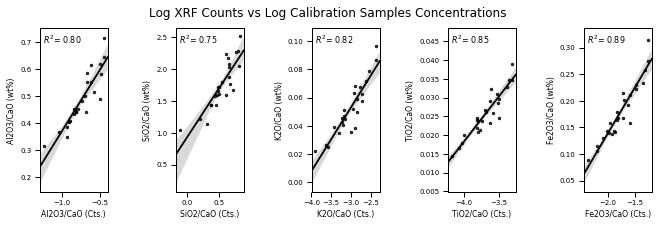

In [274]:
cts_check_ratios=df_ln_wij_over_wid_xrf.reindex(ref_conc_ratios.index,method='nearest')

sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=1,figsize=(10,3))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(1,5,i+1)
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' (wt%)')
    ax.set_xlabel(col+' (Cts.)')
plt.suptitle('Log XRF Counts vs Log Calibration Samples Concentrations',size=12)
plt.subplots_adjust(hspace=.2,wspace=1,right=.95,left=.1)

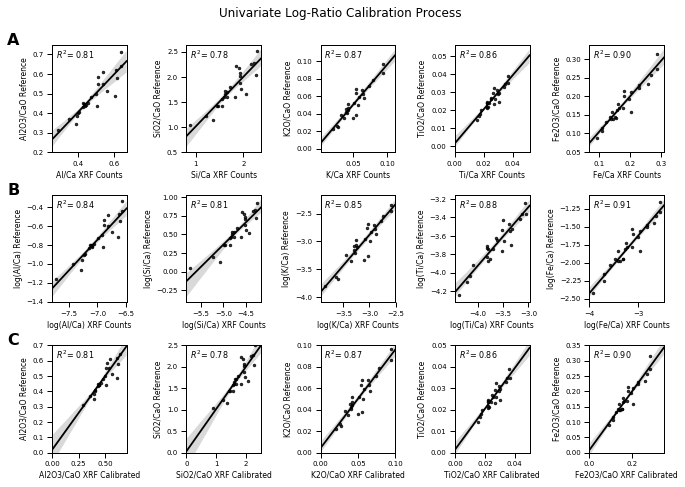

In [306]:
label_list=['Al/Ca','Si/Ca','K/Ca','Ti/Ca','Fe/Ca']
sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=5,nrows=3,figsize=(10,7.5))
for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+1)
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' Reference')
    ax.set_xlabel(label_list[i]+' XRF Counts')
    
ax.annotate('A',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')

cts_check_ratios=xrf_ratios.reindex(ref_conc_ratios.index,method='nearest')

for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+6)
    sns.regplot(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col]),
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(np.log(cts_check_ratios[col]),np.log(ref_conc_ratios[col])).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel('log('+label_list[i]+') Reference')
    ax.set_xlabel('log('+label_list[i]+') XRF Counts')

ax.annotate('B',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')
    
cts_check_ratios=calibrated_ratios.reindex(ref_conc_ratios.index,method='nearest')
lims=[(0,.7),(0,2.5),(0,.1),(0,.05),(0,.35)]

for i,col in enumerate(ref_conc_ratios.columns):
    ax=plt.subplot(3,5,i+11)
    ax.set_xlim(lims[i][0],lims[i][1])
    ax.set_ylim(lims[i][0],lims[i][1]) 
    sns.regplot(cts_check_ratios[col],ref_conc_ratios[col],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check_ratios[col],ref_conc_ratios[col]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' Reference')
    ax.set_xlabel(col+' XRF Calibrated')
   
    
ax.annotate('C',xy=(-7.8,1),xycoords='axes fraction',size=16,fontweight='bold')
    
plt.suptitle('Univariate Log-Ratio Calibration Process',size=12,y=.95)
plt.subplots_adjust(hspace=.4,wspace=.8,right=.95,left=.1)
fig.savefig(figure_path+'Figure-7 process.png',dpi=500)

# View
## CaCO3 Comparison

In [276]:
CaCO3=pd.read_csv(data_path+'carbonate_data_u1474.csv',index_col='Depth CCSF (m)')
CaCO3['%err']=CaCO3['σ %CaCO3']/CaCO3['%CaCO3']
CaCO3.sort_index(inplace=True)

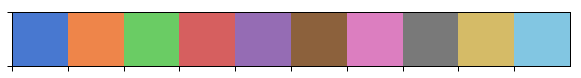

In [277]:
colors=sns.color_palette('muted',10)
sns.palplot(colors)

In [278]:
CaCO3['xrf_Ca']=calibrated.reindex(CaCO3.index,method='nearest')['CaO']
CaCO3['coul_Ca']=CaCO3['%CaCO3']*.4/.714
CaCO3['Terrigenous_Ca']=CaCO3['xrf_Ca']-CaCO3['coul_Ca']

In [279]:
(CaCO3['Terrigenous_Ca'].mean())

4.9342670328672265

In [280]:
calibrated_CaCO3=calibrated.reindex(CaCO3.index,method='nearest').dropna()
calibrated_CaCO3['Ca/Fe']=calibrated_CaCO3['CaO']/calibrated_CaCO3['Fe2O3']*.714/.69

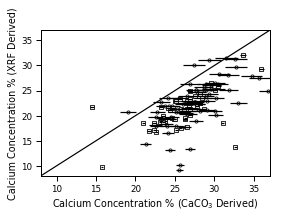

In [305]:
fig,ax=plt.subplots(figsize=(4,3))
df=CaCO3[CaCO3['Source']=='This Study']
# df.plot.scatter(x='xrf_Ca',y='coul_Ca',s=10,ax=ax,xerr=df['%err']*df['coul_Ca'],
#                 color='white',edgecolor='k',ecolor='k')
ax.scatter(df['xrf_Ca'],df['coul_Ca'],s=10,color='white',edgecolor='k')
ax.errorbar(df['xrf_Ca'],df['coul_Ca'],xerr=df['%err']*df['coul_Ca'],ecolor='k',ls='')

df=CaCO3[CaCO3['Source']=='IODP']
ax.scatter(df['xrf_Ca'],df['coul_Ca'],s=10,color='white',edgecolor='k',marker='s')
ax.errorbar(df['xrf_Ca'],df['coul_Ca'],xerr=df['%err']*df['coul_Ca'],ecolor='k',ls='')

ax.plot([0,40],[0,40],color='k')
ax.set_ylabel('Calcium Concentration % (XRF Derived)')
ax.set_xlabel('Calcium Concentration % (CaCO$_3$ Derived)')
ax.set_ylim(8,37)
ax.set_xlim(8,37)
plt.tight_layout()
fig.savefig(figure_path+'Figure-9 Ca_vs_Ca.png',dpi=700)

# Elements by Depth
Strange titanium

In [282]:
ids=calibrated[calibrated['TiO2']>1.1].index
calibrated.drop(ids,inplace=True)

In [283]:
ids=calibrated[calibrated['Fe2O3']>10.5].index
calibrated.drop(ids,inplace=True)

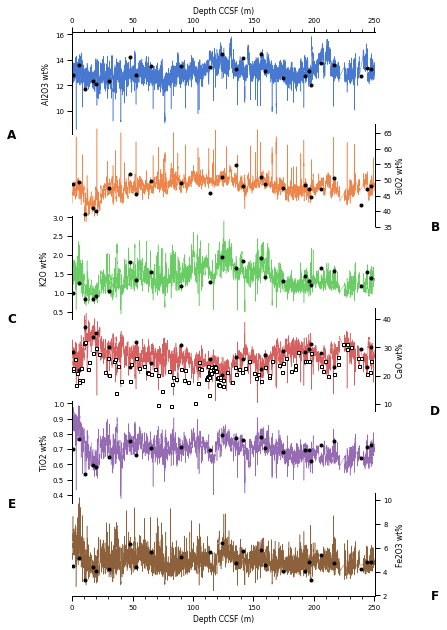

In [307]:
fig,axes=plt.subplots(nrows=6,figsize=(6,9))
sns.set_context('paper',font_scale=.8)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)
    
for i,e in enumerate(['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']):
    calibrated[e].plot(ax=axes[i],color=colors[i],lw=lw)
    reference_conc.iloc[:,i].plot(ax=axes[i],ls='',marker='o',color='k',
                                       markeredgecolor='k',markeredgewidth=1,ms=2*ms)
    axes[i].set_ylabel(e+' wt%')

(CaCO3['%CaCO3']*.4/.714).loc[:250].plot(ax=axes[3],marker='s',ls='',color='white',markeredgecolor='k',ms=2*ms)

axes[0].annotate('A',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[1].annotate('B',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[2].annotate('C',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[3].annotate('D',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[4].annotate('E',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[5].annotate('F',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')

axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth CCSF (m)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth CCSF (m)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-4 concentrations.png',dpi=700)

## Ratios by Depth

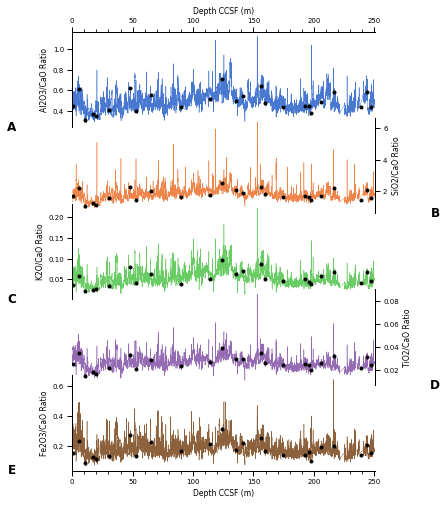

In [308]:
fig,axes=plt.subplots(nrows=5,figsize=(6,7))
sns.set_context('paper',font_scale=.8)

lw=.5
ms=1.5

sns.despine(ax=axes[0],right=True,bottom=True,top=False)
axes[0].patch.set_alpha(0)


for i,ax in enumerate(axes[1:-1]):
    if i%2==1:
        sns.despine(ax=ax,bottom=True)
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)
    else:
        sns.despine(ax=ax,left=True,bottom=True,right=False)
        ax.yaxis.set_label_position("right")
        ax.patch.set_alpha(0)
        ax.xaxis.set_visible(False)

axis=axes[-1]
if len(axes)%2==1:
    sns.despine(ax=axis)
    axis.patch.set_alpha(0)
else:
    sns.despine(ax=axis,left=True,right=False)
    axis.yaxis.set_label_position("right")
    axis.patch.set_alpha(0)
    
es=['Al2O3', 'SiO2', 'K2O', 'TiO2', 'Fe2O3']

color_list=[0,1,2,4,5]
for i,e in enumerate(['Al2O3','SiO2','K2O','TiO2','Fe2O3']):
    (calibrated[e]/calibrated['CaO']).plot(ax=axes[i],color=colors[color_list[i]],lw=lw)
    (reference_conc[es[i]]/reference_conc['CaO']).plot(ax=axes[i],ls='',marker='o',color='k',
                                       markeredgecolor='k',markeredgewidth=1,ms=2*ms)
    axes[i].set_ylabel(e+'/CaO Ratio')

axes[0].annotate('A',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[1].annotate('B',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[2].annotate('C',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[3].annotate('D',xy=(1+.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')
axes[4].annotate('E',xy=(-.2,0),
    xycoords='axes fraction',horizontalalignment='center',
    verticalalignment='center',size=12,fontweight='bold')


axes[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axes[0].xaxis.set_label_position("top")
axes[0].set_xlabel('Depth CCSF (m)')
axis=axes[-1]
axis.xaxis.set_minor_locator(AutoMinorLocator(5))
axis.set_xlabel('Depth CCSF (m)')
    
plt.subplots_adjust(hspace=-.1,top=.94,bottom=.07,right=.85,left=.15)
fig.savefig(figure_path+'Figure-5 concentrations_ratios.png',dpi=700)

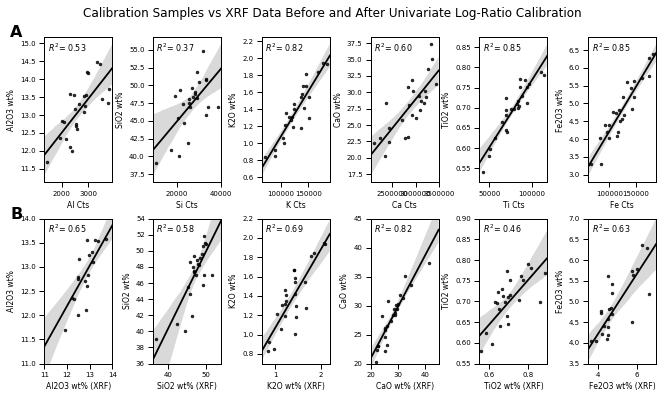

In [309]:
cts_check=xrf.reindex(reference_conc.index,method='nearest')
cts_check=cts_check[['Al','Si','K','Ca','Ti','Fe']]
axes_labels=['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']

sns.set_context('paper',font_scale=.8)
fig,axes=plt.subplots(ncols=6,nrows=2,figsize=(10,6))
for i,col in enumerate(cts_check.columns):
    ax=plt.subplot(2,6,i+1)
    sns.regplot(cts_check[col],reference_conc.iloc[:,i],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc.iloc[:,i]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(axes_labels[i]+' wt%')
    ax.set_xlabel(col+' Cts')
    
ax.annotate('A',xy=(-8.5,1),xycoords='axes fraction',size=16,fontweight='bold')


cts_check=calibrated.reindex(reference_conc.index,method='nearest')
cts_check=cts_check[['Al2O3','SiO2','K2O','CaO','TiO2','Fe2O3']]
lims=[(11,14),(36,54),(.7,2.2),(20,45),(.55,.9),(3.5,7)]

for i,col in enumerate(cts_check.columns):
    ax=plt.subplot(2,6,i+7)
    ax.set_xlim(lims[i][0],lims[i][1])
    ax.set_ylim(lims[i][0],lims[i][1])
    sns.regplot(cts_check[col],reference_conc.iloc[:,i],
                color='k',ax=ax,scatter_kws={'s':6})
    text=str('$R^2$= '+r2(cts_check[col],reference_conc.iloc[:,i]).astype(str)[:4])
    ax.text(0.05, .97, text,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=8)
    ax.set_ylabel(col+' wt%')
    ax.set_xlabel(col+' wt% (XRF)')

    
ax.annotate('B',xy=(-8.5,1),xycoords='axes fraction',size=16,fontweight='bold')
    
plt.suptitle('Calibration Samples vs XRF Data Before and After Univariate Log-Ratio Calibration',size=12,y=.95)
plt.subplots_adjust(hspace=.25,wspace=.6,right=.95,left=.1)

fig.savefig(figure_path+'Figure-8 before_after.png',dpi=500)

## Max and Min

In [287]:
print('*MAX*')
print(calibrated.max())
print('*MIN*')
print(calibrated.min())

*MAX*
Al2O3    15.831279
SiO2     66.457523
K2O       2.903417
TiO2      0.987390
Fe2O3    10.201390
CaO      42.126954
dtype: float64
*MIN*
Al2O3     8.539984
SiO2     36.575042
K2O       0.441721
TiO2      0.374440
Fe2O3     2.382535
CaO      10.389766
dtype: float64


## Mean

In [288]:
calibrated.mean()

Al2O3    13.108698
SiO2     48.042999
K2O       1.425848
TiO2      0.702957
Fe2O3     4.892905
CaO      27.036059
dtype: float64

## Percent Standard Deviation

In [289]:
calibrated.std()/calibrated.mean()*100

Al2O3     5.454653
SiO2      5.465211
K2O      20.664829
TiO2      9.284267
Fe2O3    15.232401
CaO      12.810235
dtype: float64

## Export

In [297]:
calibrated['MSE']=xrf['MSE']
calibrated['Section_Label']=xrf['SectionLabel']
calibrated['Offset (cm)']=xrf['position (mm)']/10

In [292]:
calibrated['Splice Depth CCSF (m)']=calibrated.index

In [294]:
calibrated.set_index('Splice Depth CCSF (m)',inplace=True)

In [296]:
calibrated.columns

Index(['Al2O3', 'SiO2', 'K2O', 'TiO2', 'Fe2O3', 'CaO', 'MSE',
       'Full Section Label', 'Offset (cm)'],
      dtype='object')

In [298]:
calibrated=calibrated[['Section_Label','Offset (cm)','Al2O3', 'SiO2', 'K2O', 'TiO2', 'Fe2O3', 'CaO', 'MSE']]

In [300]:
calibrated.to_csv(table_path+'Table-6 calibrated xrf data.csv')
u1474_path='/Users/danielbabin/Documents/LamontColumbia/U1474_Paper/Data/'
u1474_git_path='/Users/danielbabin/Documents/GitHub/P-Pl_Natal_Valley/Data/'
calibrated.to_csv(u1474_path+'xrf_calibrated.csv')
calibrated.to_csv(u1474_git_path+'xrf_calibrated.csv')